Setup

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch
import torch.nn
import torch.optim as optim
import sqlite3
import matplotlib.pyplot as plt
import pickle

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import normalize

# Model imports to test
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB


from DataPreprocessing import DataPreprocesser
from MyDataset import MyDataset

In [2]:
connection = sqlite3.connect('dota2.db')
cursor = connection.cursor()
MyProcesser = DataPreprocesser(connection, cursor)

Load Data

In [3]:
DataPreprocesser.to_dataframes(MyProcesser)  # Load the data into dataframes

data = MyProcesser.merge_data()

y = data.loc[:, 'radiant_win']
X = data.drop(columns=['radiant_win'])

Total number of matches available: 11392


View Data

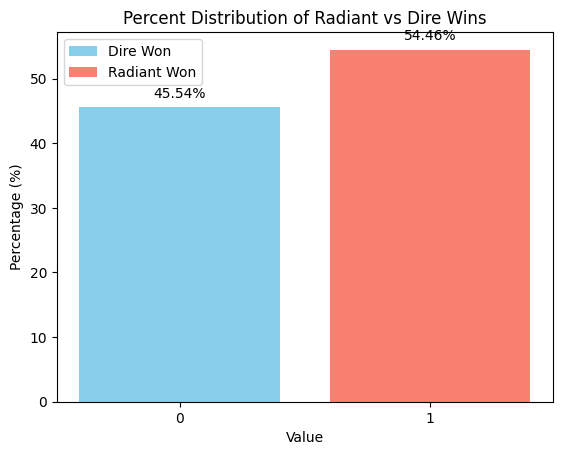

In [4]:
tmp, counts = np.unique(y, return_counts=True)
percentages = (counts / y.size) * 100

bars = plt.bar([0,1], percentages, color=['skyblue', 'salmon'])

for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Assign title and labels
plt.title('Percent Distribution of Radiant vs Dire Wins')
plt.xlabel('Value')
plt.ylabel('Percentage (%)')
bars[0].set_label('Dire Won')
bars[1].set_label('Radiant Won')

plt.legend()
plt.xticks([0,1])  # 0 is seen as a dire win, 1 is seen as a radiant win

plt.show()

Data Setup

In [5]:
# Handle NaN values
X = X.fillna(X.mean())

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
train_data = MyDataset(X_train, y_train, transforms=None)
test_data = MyDataset(X_test, y_test, transforms=None)

In [8]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

Setting Up Models

In [9]:
# I'll be testing various models to use, and employing the best one

# For now, no parameter modifications outside of default
model_configs = {
    "Logistic Regression": {'name': LogisticRegression(), 'grid': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l1', 'l1l2'], 'solver': ['lbfgs', 'liblinear', 'saga']}},
    "SVM": {'name': SVC(probability=True), 'grid': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.001, 0.01, 0.1, 1]}},
    "Decision Tree": {'name': DecisionTreeClassifier(), 'grid': { 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    "Random Forest": {'name': RandomForestClassifier(), 'grid': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}},
    "Gradient Boosting": {'name': GradientBoostingClassifier(), 'grid': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}}
}

# I want to add some neural networks to be used
neural_networks = {
    "MLP": None,
}

Tmp Model

In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Train Models & Neural Networks

In [11]:
'''
models = {}  # For saving the models after training

for name, config in model_configs.items():
    curr_grid = GridSearchCV(estimator = config['name'], param_grid=config['grid'], cv=5, scoring='accuracy')
    curr_grid.fit(X_train, y_train, )  # Does the training itself
    
    # Best Parameters
    print(f'Best parameters for {name} are: {curr_grid.best_params_}')
    
    best_model = curr_grid.best_estimator_
    
    # Used for calculating metrics
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Take the positive samples here
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    
    # AUC-ROC
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC Score: {roc_auc:.2f}")
    
    # Log Loss
    loss = log_loss(y_test, y_prob)
    print(f"Log Loss: {loss:.2f}")
    
    # Save the model
    models[name] = best_model
'''


'\nmodels = {}  # For saving the models after training\n\nfor name, config in model_configs.items():\n    curr_grid = GridSearchCV(estimator = config[\'name\'], param_grid=config[\'grid\'], cv=5, scoring=\'accuracy\')\n    curr_grid.fit(X_train, y_train, )  # Does the training itself\n    \n    # Best Parameters\n    print(f\'Best parameters for {name} are: {curr_grid.best_params_}\')\n    \n    best_model = curr_grid.best_estimator_\n    \n    # Used for calculating metrics\n    y_pred = best_model.predict(X_test)\n    y_prob = best_model.predict_proba(X_test)[:, 1]  # Take the positive samples here\n    \n    # Accuracy\n    accuracy = accuracy_score(y_test, y_pred)\n    print(f"{name} Accuracy: {accuracy * 100:.2f}%")\n    \n    # AUC-ROC\n    roc_auc = roc_auc_score(y_test, y_prob)\n    print(f"AUC-ROC Score: {roc_auc:.2f}")\n    \n    # Log Loss\n    loss = log_loss(y_test, y_prob)\n    print(f"Log Loss: {loss:.2f}")\n    \n    # Save the model\n    models[name] = best_model\n'

In [12]:
for name, item in neural_networks.items():
    pass  # Requires a more complex loop, will set up later

Evaluate Models

Performance Analysis

Save Data

In [13]:
pickle.dump(model, open('model.pkl', 'wb'))